# Predicting Ethiopian Vehicle Insurance Premiums

- The goal of this project is to clean, analyse and predict vehicle insurance premiums of the state-owned Ethiopian Insurance Corporation (one of the biggest insurance companies in Ethiopia).
- The dataset we'll use describes vehicles, their insurance premiums and other insurance related atributes from July 2011 to June 2018. It can be found on [Mendeley Data](https://data.mendeley.com/datasets/34nfrk36dt/1).



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk

#%config InlineBackend.figure_formats = ['svg']

insurance_data_1 = pd.read_csv("insuranceData/motor_data11-14lats.csv")
insurance_data_2 = pd.read_csv("insuranceData/motor_data14-2018.csv")

### Predefined function 

In [2]:
def plot_counts_and_premiums(ax, count_series, premium_series, xlabel):
    index = count_series.index
    x = np.arange(len(index))
    w = 0.4

    ax.bar(x - w/2, count_series.values, w, label='Policy Count', color='tab:red')
    ax.set_ylabel('Policy Count', color='tab:red')
    ax.tick_params(axis='y', labelcolor='tab:red')
    ax.set_xlabel(xlabel)
    ax.set_xticks(x)
    ax.set_xticklabels(index)

    ax2 = ax.twinx()
    ax2.bar(x + w/2, premium_series.loc[index].values, w, label='Premium Sum', color='tab:blue')
    ax2.set_ylabel('Premium Sum', color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

## Dataset overview

Both of the provided dataset files include the same entry attributes and differ only in entry dates. They will need to be merged.

In [3]:
insurance_data = pd.concat([insurance_data_1, insurance_data_2], ignore_index=True)

print(insurance_data.shape)

(802036, 16)


Now let's look whether the provided attributes have been read correctly.

In [4]:
insurance_data.head(10)

,SEX,INSR_BEGIN,INSR_END,EFFECTIVE_YR,INSR_TYPE,INSURED_VALUE,PREMIUM,OBJECT_ID,PROD_YEAR,SEATS_NUM,CARRYING_CAPACITY,TYPE_VEHICLE,CCM_TON,MAKE,USAGE,CLAIM_PAID
0,0,08-AUG-13,07-AUG-14,08,1202,519755.22,7209.140,5000029885,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,NaN
1,0,08-AUG-12,07-AUG-13,08,1202,519755.22,7203.890,5000029885,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,NaN
2,0,08-AUG-11,07-AUG-12,08,1202,519755.22,7045.804,5000029885,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,NaN
3,0,08-JUL-11,07-AUG-11,08,1202,519755.22,287.250,5000029885,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,NaN
4,0,08-AUG-13,07-AUG-14,08,1202,285451.24,4286.900,5000029901,2010.0,4.0,7.0,Pick-up,2494.0,TOYOTA,Own Goods,19894.43
5,0,08-AUG-12,07-AUG-13,08,1202,285451.24,4286.650,5000029901,2010.0,4.0,7.0,Pick-up,2494.0,TOYOTA,Own Goods,26916.44
6,0,08-AUG-11,07-AUG-12,08,1202,285451.24,4123.564,5000029901,2010.0,4.0,7.0,Pick-up,2494.0,TOYOTA,Own Goods,NaN
7,0,08-JUL-11,07-AUG-11,08,1202,285451.24,155.010,5000029901,2010.0,4.0,7.0,Pick-up,2494.0,TOYOTA,Own Goods,NaN
8,0,08-JUL-12,07-JUL-13,11,1201,200000.00,3452.650,5000030346,1982.0,10.0,NaN,Station Wagones,4164.0,TOYOTA,Private,NaN
9,0,08-AUG-11,07-JUL-12,11,1201,200000.00,3077.540,5000030346,1982.0,10.0,NaN,Station Wagones,4164.0,TOYOTA,Private,NaN


There are multiple entries regarding the same vehicle as it has to be reinsured every year. That can lead to up to 7 entries for the same vehicle with only the premium amout fluctuating.

In [5]:
insurance_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 802036 entries, 0 to 802035
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SEX                802036 non-null  int64  
 1   INSR_BEGIN         802036 non-null  object 
 2   INSR_END           802036 non-null  object 
 3   EFFECTIVE_YR       802032 non-null  object 
 4   INSR_TYPE          802036 non-null  int64  
 5   INSURED_VALUE      802036 non-null  float64
 6   PREMIUM            802015 non-null  float64
 7   OBJECT_ID          802036 non-null  int64  
 8   PROD_YEAR          801867 non-null  float64
 9   SEATS_NUM          801801 non-null  float64
 10  CARRYING_CAPACITY  603837 non-null  float64
 11  TYPE_VEHICLE       802036 non-null  object 
 12  CCM_TON            802028 non-null  float64
 13  MAKE               802031 non-null  object 
 14  USAGE              802036 non-null  object 
 15  CLAIM_PAID         60145 non-null   float64
dtypes:

Columns seem to have been read correctly. Let's now look at the values in individual columns.

### Sex

In [6]:
insurance_data["SEX"].value_counts()

SEX
0    415297
1    318650
2     68089
Name: count, dtype: int64

In the dataset, there are 3 unique sex values with 0 being legal entities, 1 - males and 2 - females. The number of insurance contracts in which men are the policyholders is 4,67 times greater that the number of contracts with female policyholders. That is due to women being less likely to have a drivers license in Ethiopia.

### Insurance start & end date

In [7]:
insurance_data["INSR_BEGIN"].value_counts()

INSR_BEGIN
08-JUL-17    16754
08-JUL-16    15640
08-JUL-11    15215
08-JUL-15    13464
08-JUL-14    13121
             ...  
29-MAY-13        3
28-SEP-15        3
03-MAR-15        1
12-SEP-14        1
12-SEP-12        1
Name: count, Length: 2556, dtype: int64

In [8]:
insurance_data["INSR_END"].value_counts()

INSR_END
07-JUL-18    17378
07-JUL-17    15827
07-JUL-16    14864
07-JUL-13    13594
07-JUL-15    13248
             ...  
23-OCT-11        1
13-AUG-11        1
12-SEP-11        1
13-OCT-11        1
09-AUG-11        1
Name: count, Length: 2834, dtype: int64

There do not seem to be any obvious errors in the data. Yet, we must check whether there are entries where the insurance start date is later than the end date.

In [9]:
insurance_data["INSR_BEGIN"] = pd.to_datetime(insurance_data["INSR_BEGIN"], format="%d-%b-%y")

insurance_data["INSR_END"] = pd.to_datetime(insurance_data["INSR_END"], format="%d-%b-%y")

end_greater_start = insurance_data["INSR_BEGIN"] > insurance_data["INSR_END"]
length = len(end_greater_start[end_greater_start == True])
length

0

No end values are earlier than start values. We can now visualize the variable data.

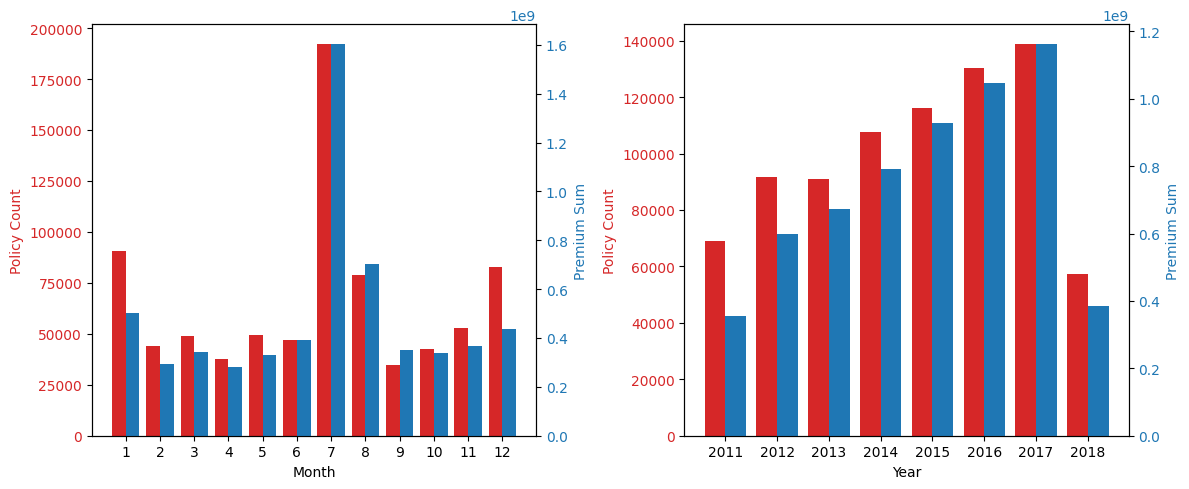

In [10]:
insurance_data["INSR_START_MONTH"] = pd.to_datetime(insurance_data["INSR_BEGIN"], format="%d-%b-%y").dt.month
insurance_data["INSR_START_YEAR"] = pd.to_datetime(insurance_data["INSR_BEGIN"], format="%d-%b-%y").dt.year

start_months = insurance_data["INSR_START_MONTH"].value_counts().sort_index()
start_months_premium = insurance_data.groupby("INSR_START_MONTH")["PREMIUM"].sum()

start_years = insurance_data["INSR_START_YEAR"].value_counts().sort_index()
start_years_premium = insurance_data.groupby("INSR_START_YEAR")["PREMIUM"].sum()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_counts_and_premiums(axes[0], start_months, start_months_premium, 'Month')
plot_counts_and_premiums(axes[1], start_years, start_years_premium, 'Year')

fig.tight_layout()
plt.show()

From the charts it becomes clear that policy count closely correlates with premium sums with regard to both the month and the year of the insurance start date. One month, July, stand out as the month in which the most policies are introduced. In terms of the trend regarding the year, there is a clear pattern of growth from 2011 to 2017 and a sharp drop off of new policies in 2018. The drop off can be explained by the end of data collection period being June of 2018. We can check if the growth up until June of 2018 is as rapid as in June of 2017.

In [11]:
before_june = insurance_data[(insurance_data["INSR_START_YEAR"].isin([2017, 2018])) & (insurance_data["INSR_START_MONTH"] < 7)]

before_june.groupby("INSR_START_YEAR").size().reset_index(name='Policy Count')

,INSR_START_YEAR,Policy Count
0,2017,55693
1,2018,57300


The pace of growth is about the same.

Let's also create a dummy variable for insurance start days.

In [12]:
insurance_data["INSR_START_DAY"] = pd.to_datetime(insurance_data["INSR_BEGIN"], format="%d-%b-%y").dt.day

### Effective year

In [13]:
insurance_data["EFFECTIVE_YR"].value_counts()

EFFECTIVE_YR
11    199888
12     86791
15     75484
14     74001
16     68866
       ...  
/1         1
IN         1
8R         1
EA         1
RS         1
Name: count, Length: 151, dtype: int64

The "EFFECTIVE_YR" column variable indicated what year the policy became effective (was first insured with the company). There are numerous records that indicate a year older that the dataset (before 2011).

Yet, the columns contain values that are not indicative of a number and should be removed. Since there are a total of 802036 records, we can afford to lose quite a few. We also need to convert the years into a four-digit number.

In [14]:
insurance_data = insurance_data[insurance_data["EFFECTIVE_YR"].astype(str).str.match(r"^\d{2}$")]

def convert_year(y):
    y = int(y)
    if y > 18:
        return 1900 + y
    else:
        return 2000 + y

insurance_data["EFFECTIVE_YR_FULL"] = insurance_data["EFFECTIVE_YR"].apply(convert_year)

insurance_data.shape

(800865, 20)

After cleaning the effective year column, we have lost 1171 rows.

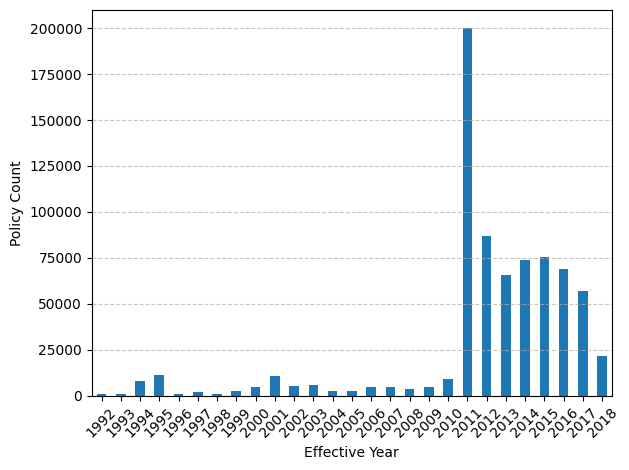

In [15]:
year_counts = insurance_data["EFFECTIVE_YR_FULL"].value_counts().sort_index()

year_counts = year_counts[
    (year_counts.index >= 1992) &
    (year_counts.index <= 2018)
]

year_counts.plot(kind='bar')
plt.xlabel("Effective Year")
plt.ylabel("Policy Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [16]:
year_counts = insurance_data["EFFECTIVE_YR_FULL"].value_counts().sort_index()
print(year_counts)

EFFECTIVE_YR_FULL
1919      394
1920      593
1921      532
1922      454
1923      488
        ...  
2014    74001
2015    75484
2016    68866
2017    57060
2018    21547
Name: count, Length: 100, dtype: int64


The data shows that most of the insured vehicles were first insured in 2011 and after. After contacting the postdoctoral fellow that published the dataset, I was informed that the meaning of this variable is not very well documented. There are values of 1947 and before eventhough, in Ethiopia, the first motor insurance was issued in 1947. This variable will be dropped.

In [17]:
insurance_data.drop(columns=["EFFECTIVE_YR", "EFFECTIVE_YR_FULL"], inplace=True)

### Insurance type

In [18]:
insurance_data["INSR_TYPE"].value_counts()

INSR_TYPE
1202    593519
1201    207011
1204       335
Name: count, dtype: int64

There are a total of three types of insurance: 1201 - private, 1202 - commercial and 1204 - motor trade road risk (for motor trade workers that drive vehicles they do not personally own, such as mechanics when testing repaired vehicles).

Let's change the values so they make more sense.

In [19]:
insurance_type_mapping = {'1202':'PRIVATE', '1201':'COMMERCIAL', '1204':'MOTOR TRADE'}

insurance_data["INSR_TYPE"] = insurance_data["INSR_TYPE"].map(insurance_type_mapping)

### Insured value

In [20]:
insurance_data["INSURED_VALUE"].value_counts()

INSURED_VALUE
0.00          343235
500000.00      13588
400000.00      12553
1500000.00     10844
600000.00      10658
               ...  
4342763.82         1
156975.00          1
329280.00          1
1094.89            1
1391526.48         1
Name: count, Length: 17368, dtype: int64

343235 vehicles in the dataset have no provided insurance value. Insured value of 0 means the policyholder has the liability insurance coverage only, not the comprehensive coverage while insured value higher than 0 indicates the comprehensive coverage.

The difference between the liability and comprehensive insurance is that liability insurance covers damage or injury you cause to other people or their property (and not repairs to your vehicle) and comprehensive insurance covers non-collision damage to your own car.

For modelling purposes we may create another variable that indicates the type of insurance the policyholder has.

In [21]:
insurance_data["INSR_COVER"] = np.where(
    insurance_data["INSURED_VALUE"] == 0,
    "liability",
    "comprehensive"
)

insurance_data["INSR_COVER"].value_counts()

INSR_COVER
comprehensive    457630
liability        343235
Name: count, dtype: int64

In [22]:
insurance_data["INSURED_VALUE"].describe()

count    8.008650e+05
mean     5.089766e+05
std      9.020327e+05
min      0.000000e+00
25%      0.000000e+00
50%      1.800000e+05
75%      7.300000e+05
max      2.500000e+08
Name: INSURED_VALUE, dtype: float64

### Object ID

In [23]:
insurance_data["OBJECT_ID"].value_counts()

OBJECT_ID
5000116673    17
5000607848    17
5000021028    16
5000036477    16
5000023438    16
              ..
5000651906     1
5000642247     1
5000642153     1
5000642151     1
5001350505     1
Name: count, Length: 288527, dtype: int64

Some vehicles appear more that 7 times which is not possible.

In [24]:
insurance_data[insurance_data["OBJECT_ID"].astype(str) == "5000116673"]

,SEX,INSR_BEGIN,INSR_END,INSR_TYPE,INSURED_VALUE,PREMIUM,OBJECT_ID,PROD_YEAR,SEATS_NUM,CARRYING_CAPACITY,TYPE_VEHICLE,CCM_TON,MAKE,USAGE,CLAIM_PAID,INSR_START_MONTH,INSR_START_YEAR,INSR_START_DAY,INSR_COVER
75918,1,2013-07-31,2014-07-30,NaN,414000.0,6564.04,5000116673,2006.0,0.0,220.0,Trailers and semitrailers,0.0,MESFIN,General Cartage,NaN,7,2013,31,comprehensive
75919,0,2013-07-08,2014-07-07,NaN,120000.0,2643.35,5000116673,2006.0,0.0,220.0,Trailers and semitrailers,0.0,MESFIN,General Cartage,NaN,7,2013,8,comprehensive
75920,0,2012-11-04,2013-07-07,NaN,241442.0,3802.86,5000116673,2006.0,0.0,220.0,Trailers and semitrailers,0.0,MESFIN,General Cartage,NaN,11,2012,4,comprehensive
75921,0,2012-09-08,2012-11-03,NaN,241442.0,1191.43,5000116673,2006.0,0.0,220.0,Trailers and semitrailers,0.0,MESFIN,General Cartage,NaN,9,2012,8,comprehensive
75922,1,2012-07-31,2013-07-30,NaN,414000.0,4473.66,5000116673,2006.0,0.0,220.0,Trailers and semitrailers,0.0,MESFIN,General Cartage,NaN,7,2012,31,comprehensive
75923,0,2012-07-08,2012-09-07,NaN,241442.0,1966.70,5000116673,2006.0,0.0,220.0,Trailers and semitrailers,0.0,MESFIN,General Cartage,NaN,7,2012,8,comprehensive
75924,1,2011-07-31,2012-07-30,NaN,414000.0,3718.13,5000116673,2006.0,0.0,220.0,Trailers and semitrailers,0.0,MESFIN,General Cartage,NaN,7,2011,31,comprehensive
75925,0,2011-10-08,2012-07-07,NaN,241442.0,4136.43,5000116673,2006.0,0.0,220.0,Trailers and semitrailers,0.0,MESFIN,General Cartage,NaN,10,2011,8,comprehensive
75926,0,2011-07-08,2011-10-07,NaN,241442.0,1028.48,5000116673,2006.0,0.0,220.0,Trailers and semitrailers,0.0,MESFIN,General Cartage,NaN,7,2011,8,comprehensive
359619,1,2018-03-31,2019-03-30,NaN,600000.0,5576.76,5000116673,2006.0,0.0,220.0,Trailers and semitrailers,0.0,MESFIN,General Cartage,NaN,3,2018,31,comprehensive


In [25]:
(insurance_data["OBJECT_ID"].value_counts() > 7).sum()

7269

There are a total of 7268 OBJECT_IDs that apprear more than 7 times. Correcting each one would have to be done manually by hand and therefore it would be much simpler just to remove the entries completely. In a real-world scenario irregular values should be investigated.

In [26]:
object_id_counts = insurance_data["OBJECT_ID"].value_counts()

ids_to_remove = object_id_counts[object_id_counts > 7].index

insurance_data = insurance_data[~insurance_data["OBJECT_ID"].isin(ids_to_remove)]

print(insurance_data.shape)

(739558, 19)


### Year of production

In [27]:
insurance_data["PROD_YEAR"].value_counts()

PROD_YEAR
2012.0    59366
2014.0    51739
2015.0    46560
2013.0    43964
2010.0    42433
          ...  
1953.0       12
1955.0        5
1954.0        5
1951.0        5
1952.0        3
Name: count, Length: 69, dtype: int64

There are no abnormalities in this attribute.

### Number of seats

In [28]:
insurance_data["SEATS_NUM"].value_counts()

SEATS_NUM
4.0      211613
1.0      142817
2.0       90399
3.0       82427
0.0       53879
          ...  
199.0         1
112.0         1
125.0         1
178.0         1
71.0          1
Name: count, Length: 94, dtype: int64

There are a total of 53866 vehicles with 0 seats which is impossible. Also, the number of seats should not exceed 256 (seats in the largest bus in the world).

In [29]:
insurance_data = insurance_data[(insurance_data["SEATS_NUM"] > 0) & (insurance_data["SEATS_NUM"] <= 256)]

print(insurance_data.shape)

(685444, 19)


### Carrying capacity

In [30]:
insurance_data["CARRYING_CAPACITY"].value_counts()

CARRYING_CAPACITY
0.0         206940
7.0          55346
10.0         33951
3.0          23894
6.0          20817
             ...  
161.1            1
62.3             1
9253.0           1
6925.0           1
130000.0         1
Name: count, Length: 2142, dtype: int64

It is clear that the seat number variable and the carrying capacity variable are not clearly differentiated. They have been mixed up and should be removed.

In [31]:
insurance_data.drop(columns=["SEATS_NUM", "CARRYING_CAPACITY"], inplace=True)

### Vehicle type

In [32]:
insurance_data["TYPE_VEHICLE"].value_counts()

TYPE_VEHICLE
Motor-cycle                  138147
Truck                        133820
Pick-up                      128905
Automobile                   113938
Bus                           98710
Station Wagones               51191
Tanker                         9006
Special construction           7153
Tractor                        4041
Trailers and semitrailers       533
Name: count, dtype: int64

Nothing out of the ordinary here.

### Vehicle Weight

In [33]:
insurance_data["CCM_TON"].value_counts()

CCM_TON
4164.0     52168
0.0        39414
2494.0     38604
200.0      30761
4334.0     24197
           ...  
4546.0         1
929.0          1
13478.0        1
2384.0         1
363.6          1
Name: count, Length: 3608, dtype: int64

This variable is related to the weight of the vehicle. Since it is not clearly described how, we will remove it.

In [34]:
insurance_data.drop(columns=["CCM_TON"], inplace=True)

### Vehicle maker

In [35]:
insurance_data["MAKE"].value_counts()

MAKE
TOYOTA                  244348
ISUZU                    69448
BAJAJI                   67072
NISSAN                   30930
BAJAJ                    17679
                         ...  
BEYBEN TRUCK                 1
APPACH EBS                   1
ISUZU NPRP                   1
CALDINESS FORK LIFTS         1
GROVE                        1
Name: count, Length: 657, dtype: int64

In [36]:
insurance_data["MAKE"].value_counts()[insurance_data["MAKE"].value_counts() == 1]

MAKE
TOYOTA MERCHEDIS        1
NISSAN X-TRIAL          1
DONG FENGSHEN           1
MOTOR CYLE              1
LOADER POERR PLUS       1
                       ..
BEYBEN TRUCK            1
APPACH EBS              1
ISUZU NPRP              1
CALDINESS FORK LIFTS    1
GROVE                   1
Name: count, Length: 105, dtype: int64

There are 105 vehicle makers that appear only once and are most likely typos, with 'TOYOTA MERCHEDIS' being the most humorous one. A few entries can be saved by searching for a partial name match with the makers that appear at least a 1000 times.

In [37]:
common_makers = insurance_data["MAKE"].value_counts()
common_makers = common_makers[common_makers >= 1000].index.tolist()

def clean_maker(maker):
    maker_up = str(maker).upper()
    for brand in common_makers:
        if brand in maker_up:
            return brand
    return maker

insurance_data["MAKE"] = insurance_data["MAKE"].apply(clean_maker)

insurance_data["MAKE"].value_counts()[insurance_data["MAKE"].value_counts() == 1].shape[0]

87

87 vehicles with an unclear maker are still left. They will be removed.

In [38]:
make_counts = insurance_data["MAKE"].value_counts()
single_makers = make_counts[make_counts == 1].index.tolist()

insurance_data = insurance_data[~insurance_data["MAKE"].isin(single_makers)]

### Primary function of vehicle

In [39]:
insurance_data["USAGE"].value_counts()

USAGE
Own Goods                 181554
Private                   180879
Fare Paying Passengers    115316
General Cartage            93313
Taxi                       46511
Own service                44361
Others                      8311
Special Construction        3128
Ambulance                   2931
Learnes                     2624
Car Hires                   2391
Agricultural Own Farm       2296
Agricultural Any Farm       1640
Fire fighting                102
Name: count, dtype: int64

All functions seem valid.

### Paid claim sum

In [40]:
insurance_data["CLAIM_PAID"] = insurance_data["CLAIM_PAID"].replace(np.nan, 0)

pd.set_option('display.float_format', '{:.2f}'.format)

print(insurance_data["CLAIM_PAID"].describe())

count      685357.00
mean        19114.78
std        434009.11
min             0.00
25%             0.00
50%             0.00
75%             0.00
max     152445764.90
Name: CLAIM_PAID, dtype: float64


The payout values seem realistic since they are in Ethiopian birr.

### Insurance premium

The premium amount are provided in Ethiopian birr (1000 Birr = 7,3 USD).

In [41]:
insurance_data["PREMIUM"][insurance_data["PREMIUM"] <= 0].count()

10

There are 29 vehicles with a premium of 0 or less. This is not acceptable and we will remove them. I was informed by the publisher of the dataset that the company follows a principle of "No premium, no insurance". This method of record keeping is ineffective.

In [42]:
insurance_data = insurance_data[insurance_data["PREMIUM"] > 0]

In [43]:
insurance_data["PREMIUM"].describe()

count   685328.00
mean      7440.27
std      10862.19
min          2.98
25%        726.75
50%       3016.30
75%       9611.27
max     330818.54
Name: PREMIUM, dtype: float64

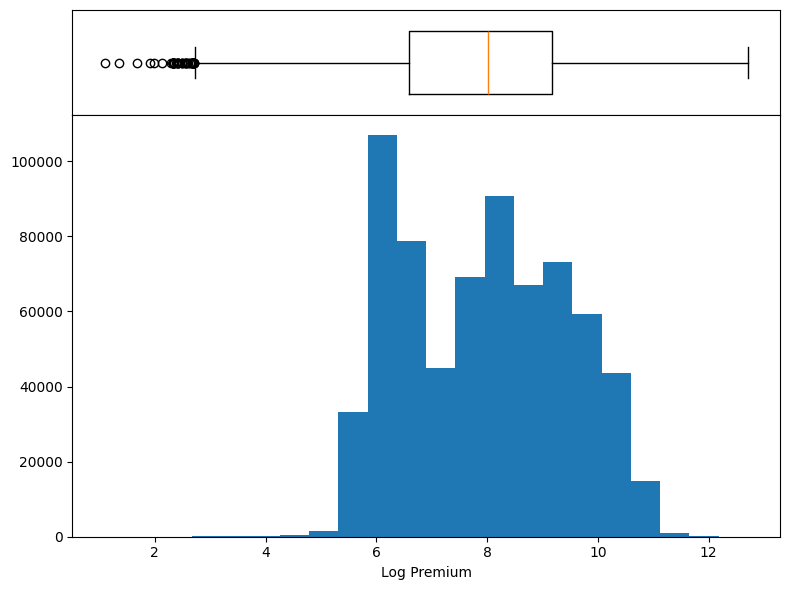

In [ ]:
log_premiums = np.log(insurance_data["PREMIUM"])

fig, axes = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'height_ratios': [1, 4]})

axes[0].boxplot(log_premiums, vert=False, widths=0.6)
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].hist(log_premiums, bins=22)
axes[1].set_xlabel('Log Premium')

plt.tight_layout(h_pad=0)

plt.show()

### Modelling

In [45]:
insurance_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 685328 entries, 8 to 802035
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   SEX               685328 non-null  int64         
 1   INSR_BEGIN        685328 non-null  datetime64[ns]
 2   INSR_END          685328 non-null  datetime64[ns]
 3   INSR_TYPE         0 non-null       object        
 4   INSURED_VALUE     685328 non-null  float64       
 5   PREMIUM           685328 non-null  float64       
 6   OBJECT_ID         685328 non-null  int64         
 7   PROD_YEAR         685325 non-null  float64       
 8   TYPE_VEHICLE      685328 non-null  object        
 9   MAKE              685328 non-null  object        
 10  USAGE             685328 non-null  object        
 11  CLAIM_PAID        685328 non-null  float64       
 12  INSR_START_MONTH  685328 non-null  int32         
 13  INSR_START_YEAR   685328 non-null  int32         
 14  INSR_STAR

We are left with 12 variables that could be used for modelling: SEX, INSR_TYPE, INSURED_VALUE, PROD_YEAR, TYPE_VEHICLE, MAKE, USAGE, CLAIM_PAID, INSR_COVER, INSR_START_DAY, INSR_START_MONTH and INSR_START_YEAR.

In [46]:
model = sk.linear_model.LinearRegression()

X = insurance_data[["INSR_TYPE", "INSURED_VALUE", "CLAIM_PAID", "INSR_COVER"]].copy()

X = pd.get_dummies(X, columns=["INSR_TYPE", "INSR_COVER"], drop_first=True)

Y = insurance_data["PREMIUM"]

X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, test_size=0.2, random_state=87)

model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

r_sq = model.score(X_test, Y_test)

mae = sk.metrics.mean_absolute_error(Y_test, Y_pred)

r_sq, mae

(0.5606435427355265, 4112.2205780350105)

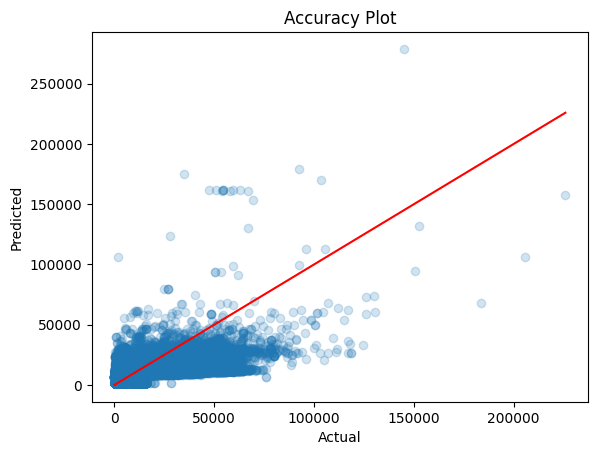

In [47]:
plt.scatter(Y_test, Y_pred, alpha=0.2)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r')
plt.title("Accuracy Plot")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

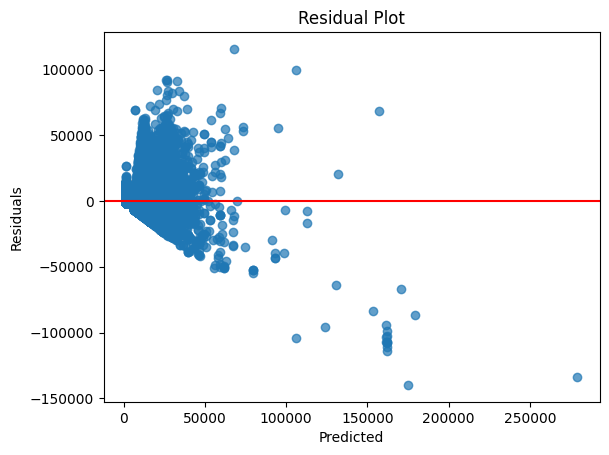

In [ ]:
plt.scatter(Y_pred, Y_test - Y_pred, alpha=0.7)
plt.axhline(y=0, color='r')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [49]:
correlation = np.corrcoef(Y_test, Y_pred)[0, 1]
print(f"Correlation: {correlation:.2f}")

Correlation: 0.75


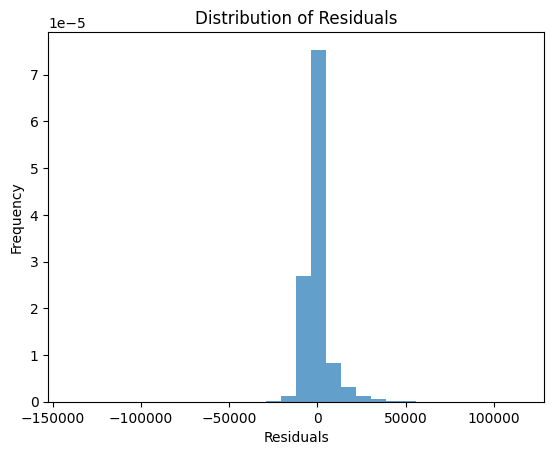

In [50]:
plt.hist(Y_test - Y_pred, bins=30, density=True, alpha=0.7)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()